
# Imports, preparation

In [1]:
import os
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Conv3D, MaxPool3D, Dropout, Conv3DTranspose, Reshape, Lambda, UpSampling3D, ZeroPadding3D, CategoryEncoding, Softmax
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
import keras
from keras import layers
from keras import backend as K
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sklearn

np.set_printoptions(suppress=True)
tf.debugging.disable_traceback_filtering()

## TPU

In [2]:
use_tpu = False #@param {type: "boolean"}

if use_tpu:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        tpu_strategy = tf.distribute.TPUStrategy(tpu)
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except:
        print('Something went wrong when connecting to a TPU')

# Data loading and preparation

In [3]:
DATASET_PATH = './dataset/'
MODELS_PATH = './models/'

## gdrive

In [4]:
import sys
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    DATASET_PATH = '/content/drive/MyDrive/ZMUMIG/dataset/'
    MODELS_PATH = '/content/drive/MyDrive/ZMUMIG/models/'
except:
    print('probably not using google colab')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Dataset loading

In [5]:
PALETTE = pd.read_csv(os.path.join(DATASET_PATH, 'palette-v0.1.csv'))
CHUNK_XZ = 16
CHUNK_Y = 156
TOP_XZ = 16
TOP_Y = 16
print(PALETTE)
CHUNK_DATASET = {}
TOPS_DATASET = {}
BIOMES = ['desert', 'forest', 'plains', 'savanna']
BIOME_COUNT = 4
DISTINCT_BLOCKS = len(PALETTE)
for i, biome in enumerate(BIOMES):
    tops_file = os.path.join(DATASET_PATH, 'tops', biome + '.npz')
    chunks_file = os.path.join(DATASET_PATH, 'whole_chunks', biome + '.npz')

    chunks = np.load(chunks_file)
    tops = np.load(tops_file)

    unshaped_chunks = chunks['y']
    shaped_tops = tops['y']

    chunk_size = CHUNK_XZ*CHUNK_XZ*CHUNK_Y
    chunk_count = len(unshaped_chunks)//chunk_size
    reshaped_chunks = unshaped_chunks.reshape(chunk_count, CHUNK_Y, CHUNK_XZ, CHUNK_XZ)
    CHUNK_DATASET[i] = reshaped_chunks.astype(np.uint8)
    TOPS_DATASET[i] = shaped_tops.astype(np.uint8)
    print(f"biome '{biome}' has {reshaped_chunks.shape[0]} chunks")
    print(f"biome '{biome}' has {shaped_tops.shape[0]} tops")

    id                block_type
0    0           minecraft:stone
1    1        minecraft:iron_ore
2    2          minecraft:gravel
3    3            minecraft:dirt
4    4        minecraft:gold_ore
5    5           minecraft:water
6    6        minecraft:coal_ore
7    7             minecraft:air
8    8            minecraft:lava
9    9       minecraft:sandstone
10  10            minecraft:sand
11  11       minecraft:dead_bush
12  12            minecraft:clay
13  13      minecraft:sugar_cane
14  14     minecraft:diamond_ore
15  15      minecraft:tall_grass
16  16     minecraft:short_grass
17  17          minecraft:cactus
18  18     minecraft:grass_block
19  19      minecraft:oak_leaves
20  20       minecraft:oak_fence
21  21          minecraft:cobweb
22  22      minecraft:oak_planks
23  23           minecraft:poppy
24  24       minecraft:dandelion
25  25         minecraft:oak_log
26  26         minecraft:pumpkin
27  27  minecraft:brown_mushroom
28  28     minecraft:cobblestone
biome 'des

## Statistics

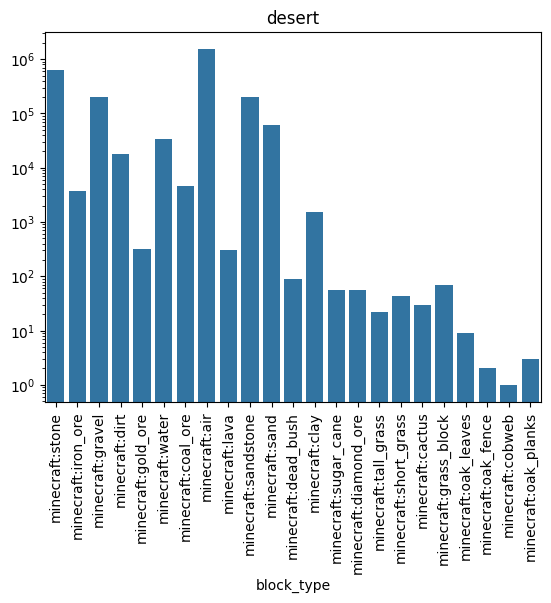

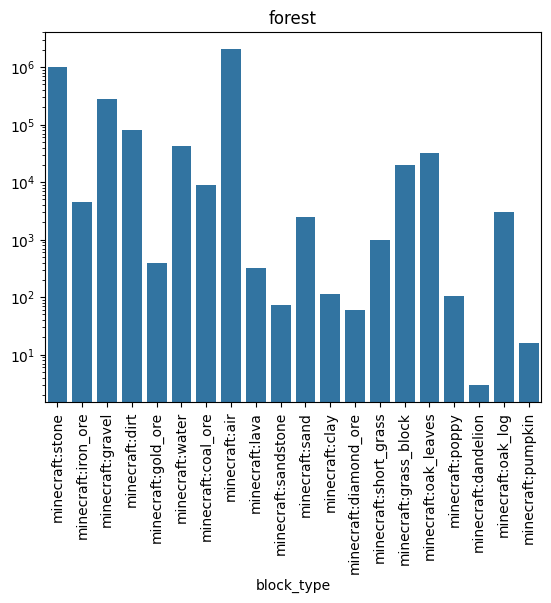

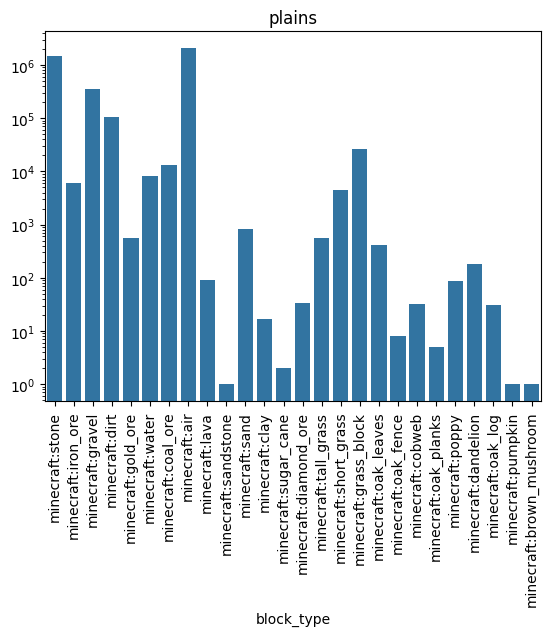

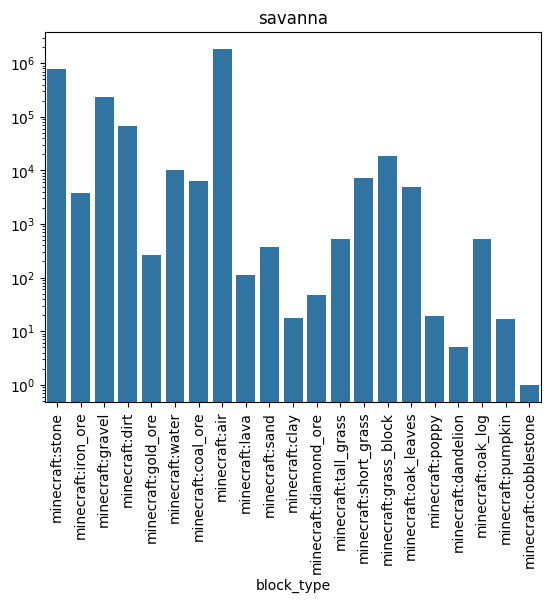

In [6]:
for i, biome in enumerate(BIOMES):
    voxels = CHUNK_DATASET[i]
    unique, counts = np.unique(voxels, return_counts=True)
    # print(palette['block_type'][unique])
    # print(counts)
    sns.barplot(x= PALETTE['block_type'][unique], y = counts).set(title=BIOMES[i])
    plt.xticks(rotation=90)
    plt.yscale('log')
    plt.show()

# structudized-latent-space-AE

In [7]:
dimensions = DISTINCT_BLOCKS # 29
latent_dimensions = 3

## Definition

### Custom class & layers

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, latent_dimensions, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.structurization_loss_tracker = keras.metrics.Mean(name="structurization_loss")
        self.latent_dimensions = latent_dimensions

    def get_filter(self):
        s = 1.0
        c = 1.0/1.41421356237
        q = 1.0/1.73205080757
        n = 4
        sum = (12*c+8*q+6*s+n)
        s = s/sum
        c = c/sum
        q = q/sum
        n = n/sum
        lookup = [
            [
                [q, c, q],
                [c, s, c],
                [q, c, q]
            ],
            [
                [c, s, c],
                [s, n, s],
                [c, s, c]
            ],
            [
                [q, c, q],
                [c, s, c],
                [q, c, q]
            ],
        ]
        filter = np.zeros(shape=(3, 3, 3, self.latent_dimensions, self.latent_dimensions))
        for x in range(0, 3):
          for y in range(0, 3):
            for z in range(0, 3):
              for i in range(0, self.latent_dimensions):
                for o in range(0, self.latent_dimensions):
                  if i == o:
                    filter[x,y,z,i,o] = lookup[x][y][z]
                  else:
                    filter[x,y,z,i,o] = 0
        return filter

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.structurization_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_mean(
                    keras.losses.sparse_categorical_crossentropy(data, reconstruction, axis=4,),
                    axis=(1, 2, 3),
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_mean(
                    -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=(1, 2, 3),
                )
            )
            averages = tf.nn.conv3d(z, filters= tf.constant(self.get_filter(), dtype=z.dtype), strides=[1, 1, 1, 1, 1], padding='SAME')
            structurization_loss = tf.reduce_mean(
                tf.reduce_mean(
                    tf.math.reduce_euclidean_norm(z-averages, axis=4,),
                    axis=(1,2,3)
                )
            )
            total_loss = reconstruction_loss + 0.05 * kl_loss + structurization_loss * 1
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.structurization_loss_tracker.update_state(structurization_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "structurization_loss": self.structurization_loss_tracker.result(),
        }

    def test_step(self, data):
        x = tf.cast(data, tf.int64)
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_mean(
                keras.losses.sparse_categorical_crossentropy(x, reconstruction, axis=4),
                axis=(1, 2, 3),
            )
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_mean(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=(1, 2, 3),
            )
        )
        averages = tf.nn.conv3d(z, filters= tf.constant(self.get_filter(), dtype=z.dtype), strides=[1, 1, 1, 1, 1], padding='SAME')
        structurization_loss = tf.reduce_mean(
            tf.reduce_mean(
                tf.math.reduce_euclidean_norm(z-averages, axis=4,),
                axis=(1,2,3)
            )
        )
        total_loss = reconstruction_loss + 0.05 * kl_loss + structurization_loss * 1
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.structurization_loss_tracker.update_state(structurization_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "structurization_loss": self.structurization_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z_mean)
        return reconstruction

In [9]:
@keras.saving.register_keras_serializable('mcdiffusion')
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        g = tf.random.get_global_generator()
        epsilon = g.normal(shape=tf.shape(z_mean), mean=0., stddev=1)
        value = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return value

@keras.saving.register_keras_serializable('mcdiffusion')
class OneHot(layers.Layer):
    def call(self, input):
        return tf.one_hot(input, DISTINCT_BLOCKS, on_value=1.0, off_value=0.0, axis=-1)

### VAE Decoder, Encoder layers

In [10]:
def create_vae_encoder(dimensions, latent_dimensions):
    input = Input(shape=(None, None, None), dtype='uint8', name='encoder_input')
    l = OneHot()(input)
    l  = Conv3D(30, kernel_size=1, activation='elu', padding='same', kernel_initializer = 'glorot_normal')(l)
    l  = Conv3D(40, kernel_size=1, activation='elu', padding='same', kernel_initializer = 'glorot_normal')(l)
    l  = Conv3D(40, kernel_size=1, activation='elu', padding='same', kernel_initializer = 'glorot_normal')(l)
    l  = Conv3D(40, kernel_size=1, activation='elu', padding='same', kernel_initializer = 'glorot_normal')(l)
    l1  = Conv3D(20, kernel_size=1, activation='elu', padding='same', kernel_initializer = 'glorot_normal')(l)
    l1  = Conv3D(20, kernel_size=1, activation='elu', padding='same', kernel_initializer = 'glorot_normal')(l1)
    l2  = Conv3D(20, kernel_size=1, activation='elu', padding='same', kernel_initializer = 'glorot_normal')(l)
    l2  = Conv3D(20, kernel_size=1, activation='elu', padding='same', kernel_initializer = 'glorot_normal')(l)
    mean = Conv3D(latent_dimensions, kernel_size=1, activation='linear', name='mean')(l1)
    var = Conv3D(latent_dimensions, kernel_size=1, activation='linear', kernel_initializer = 'zeros', name ='var')(l2)
    z = Sampling(name='encoder_output')([mean, var])
    encoder = keras.Model(input, [mean, var, z], name="encoder")
    return encoder

def create_vae_decoder(dimensions, latent_dimensions):
    input = Input(shape=(None, None, None, latent_dimensions), name='decoder_input')
    l = input
    l = Conv3D(20, kernel_size=1, activation='elu')(l)
    l = Conv3D(30, kernel_size=1, activation='elu')(l)
    l = Conv3D(40, kernel_size=1, activation='elu')(l)
    l = Conv3D(40, kernel_size=1, activation='elu')(l)
    l = Conv3D(40, kernel_size=1, activation='elu')(l)
    l = Conv3D(30, kernel_size=1, activation='elu')(l)
    l = Conv3D(dimensions, kernel_size=1, activation='linear', name='decoder_output')(l)
    l = Softmax(axis=4)(l)
    decoder = keras.Model(input, l, name="decoder")
    return decoder

## Loading or construction

In [11]:
#@title Load or construct the VAE
encoder_file = "encoder.keras"
decoder_file = "decoder.keras"
load_VAE = True #@param {type: "boolean"}

if load_VAE:
    encoder = keras.models.load_model(os.path.join(MODELS_PATH, encoder_file))
    decoder = keras.models.load_model(os.path.join(MODELS_PATH, decoder_file))
    print('encoded and decoder loaded')
else:
    encoder = create_vae_encoder(dimensions, latent_dimensions)
    decoder = create_vae_decoder(dimensions, latent_dimensions)
    print('encoded and decoder constructed')
vae = VAE(encoder, decoder, latent_dimensions, name='VAE')
encoder.summary()
decoder.summary()

encoded and decoder loaded
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, None, None, None)]   0         []                            
                                                                                                  
 one_hot_1 (OneHot)          (None, None, None, None, 2   0         ['encoder_input[0][0]']       
                             9)                                                                   
                                                                                                  
 conv3d_14 (Conv3D)          (None, None, None, None, 3   900       ['one_hot_1[0][0]']           
                             0)                                                                   
                                                                 

## Training

In [284]:
vae.compile(optimizer=keras.optimizers.Adam())

In [13]:
#@ Per-block-type validation data
#@title Per-block-type validation data
vae_validation_data_x = np.arange(DISTINCT_BLOCKS)
vae_validation_data_x = np.reshape(vae_validation_data_x, (DISTINCT_BLOCKS, 1, 1, 1));
vae_validation_data_y = np.zeros((DISTINCT_BLOCKS, DISTINCT_BLOCKS))
vae_validation_data_y[np.arange(DISTINCT_BLOCKS), vae_validation_data_x] = 1
vae_validation_data_x = vae_validation_data_x.astype(np.uint8)
vae_validation_data_y = vae_validation_data_y.astype(np.uint8)
print(vae_validation_data_x.shape, vae_validation_data_y.shape)

(29, 1, 1, 1) (29, 29)


In [25]:
#@title Data pipeline

def random_point_dataset_generator(y_size, xz_size):
    while True:
        biome = np.random.randint(0, BIOME_COUNT)
        chunk_id = np.random.randint(0, CHUNK_DATASET[biome].shape[0])
        pos_y = np.random.randint(0, CHUNK_Y - y_size)
        pos_x = np.random.randint(0, CHUNK_XZ - xz_size)
        pos_z = np.random.randint(0, CHUNK_XZ - xz_size)
        yield (biome, chunk_id, pos_y, pos_x, pos_z, y_size, xz_size)

def fetch_array(biome_id, chunk_id, pos_y, pos_x, pos_z, y_size, xz_size):
    arr = np.zeros((y_size, xz_size, xz_size)).astype(np.uint8)
    pos_ym = pos_y+y_size
    pos_xm = pos_x+xz_size
    pos_zm = pos_z+xz_size
    arr[:,:,:] = CHUNK_DATASET[biome_id][chunk_id, pos_y:pos_ym, pos_x:pos_xm, pos_z:pos_zm]
    return arr

def wrapped_fetch_array(biome_id, chunk_id, pos_y, pos_x, pos_z, y_size, xz_size):
    return tf.numpy_function(func = fetch_array,
                      inp = (biome_id, chunk_id, pos_y, pos_x, pos_z, y_size, xz_size),
                      Tout = (tf.uint8))

def create_VAE_dataset_from_generator(y, xz):
    return tf.data.Dataset.from_generator(
        random_point_dataset_generator,
        output_types=(tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32),
        output_shapes=([], [], [], [], [], [], []),
        args=(y, xz)
    ).map( # Parallelize map transformation
        wrapped_fetch_array,
        num_parallel_calls=tf.data.AUTOTUNE
    )

vae_training_dataset = create_VAE_dataset_from_generator(10, 10) \
    .batch(256) \
    .prefetch(tf.data.AUTOTUNE)

# testing:
print(next(iter(create_VAE_dataset_from_generator(12, 12))).shape)

(12, 12, 12)


### Purely contextual

In [285]:
history = vae.fit(vae_training_dataset, epochs=10, steps_per_epoch=100, validation_data=(vae_validation_data_x, None))
def plot_history(history):
    for k in history.history.keys():
        plt.plot(history.history[k])
        plt.title('history')
        plt.xlabel('epoch')
    plt.legend(history.history.keys(), loc='upper left')
    plt.show()
plot_history(history)

Epoch 1/10
100/100 [==============================] - 16s 120ms/step - loss: 0.2680 - reconstruction_loss: 0.0031 - kl_loss: 2.8313 - structurization_loss: 0.0853 - val_loss: 0.7719 - val_reconstruction_loss: 0.0480 - val_kl_loss: 2.7044 - val_structurization_loss: 0.5887
Epoch 2/10
100/100 [==============================] - 11s 115ms/step - loss: 0.2069 - reconstruction_loss: 0.0016 - kl_loss: 3.0258 - structurization_loss: 0.0535 - val_loss: 0.8803 - val_reconstruction_loss: 0.2579 - val_kl_loss: 2.9076 - val_structurization_loss: 0.4771
Epoch 3/10
100/100 [==============================] - 12s 117ms/step - loss: 0.3048 - reconstruction_loss: 0.0796 - kl_loss: 3.1507 - structurization_loss: 0.1401 - val_loss: 2.1330 - val_reconstruction_loss: 1.1254 - val_kl_loss: 3.0489 - val_structurization_loss: 0.8552
Epoch 4/10
100/100 [==============================] - 12s 123ms/step - loss: 0.2998 - reconstruction_loss: 0.0010 - kl_loss: 2.7753 - structurization_loss: 0.1432 - val_loss: 1.1640

KeyboardInterrupt: 

### Interleaved with single-class

In [39]:
one_to_one_size = 10

one_to_one_vae_data = np.repeat(vae_validation_data_x, one_to_one_size, axis = 1)
one_to_one_vae_data = np.repeat(one_to_one_vae_data, one_to_one_size, axis = 2)
one_to_one_vae_data = np.repeat(one_to_one_vae_data, one_to_one_size, axis = 3)

vae_one_to_one_slices = tf.data.Dataset.from_tensor_slices(one_to_one_vae_data).repeat()
vae_one_to_one = vae_one_to_one_slices.batch(256)
choice_dataset = tf.data.Dataset.from_tensor_slices(np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]).astype(np.int64)).repeat()
interleaved_vae_dataset = tf.data.Dataset.choose_from_datasets([vae_one_to_one_slices, create_VAE_dataset_from_generator(10, 10)], choice_dataset) \
    .batch(256) \
    .prefetch(tf.data.AUTOTUNE)

In [287]:
history = vae.fit(interleaved_vae_dataset, epochs=10, steps_per_epoch=400, validation_data=(vae_validation_data_x, None))
def plot_history(history):
    for k in history.history.keys():
        plt.plot(history.history[k])
        plt.title('history')
        plt.xlabel('epoch')
    plt.legend(history.history.keys(), loc='upper left')
    plt.show()
plot_history(history)

Epoch 1/10
400/400 [==============================] - 19s 47ms/step - loss: 0.2838 - reconstruction_loss: 0.0078 - kl_loss: 3.1508 - structurization_loss: 0.0844 - val_loss: 0.4281 - val_reconstruction_loss: 0.0044 - val_kl_loss: 3.2293 - val_structurization_loss: 0.2623
Epoch 2/10
400/400 [==============================] - 19s 48ms/step - loss: 0.2269 - reconstruction_loss: 0.0034 - kl_loss: 3.2543 - structurization_loss: 0.0593 - val_loss: 0.3765 - val_reconstruction_loss: 0.0011 - val_kl_loss: 3.3148 - val_structurization_loss: 0.2096
Epoch 3/10
400/400 [==============================] - 19s 46ms/step - loss: 0.2229 - reconstruction_loss: 0.0031 - kl_loss: 3.3054 - structurization_loss: 0.0542 - val_loss: 0.3649 - val_reconstruction_loss: 8.7730e-04 - val_kl_loss: 3.3385 - val_structurization_loss: 0.1971
Epoch 4/10
 26/400 [>.............................] - ETA: 16s - loss: 0.2219 - reconstruction_loss: 0.0029 - kl_loss: 3.3187 - structurization_loss: 0.0530

KeyboardInterrupt: 

## Evaluation

1/1 [==============================] - 1s 719ms/step


Text(0.5, 1.0, 'confusion matrix')

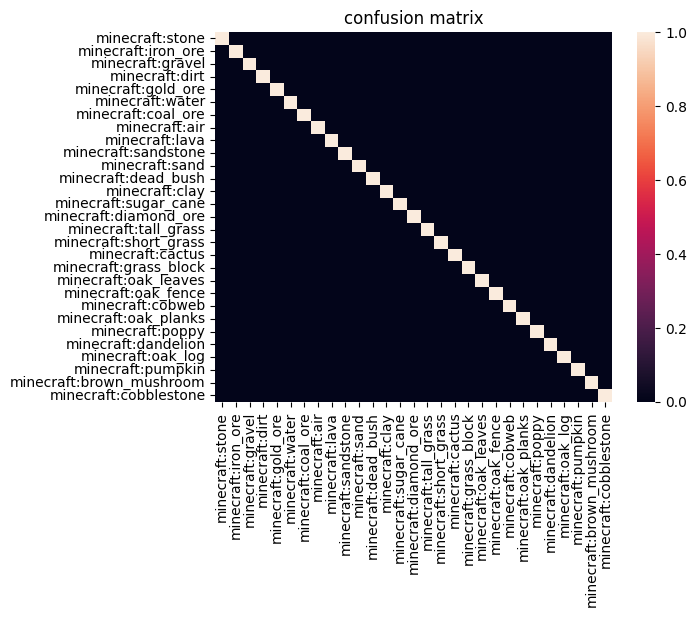

In [14]:
import sklearn.metrics

result = vae.predict(vae_validation_data_x)
blocks_in = vae_validation_data_x.reshape(DISTINCT_BLOCKS)
blocks_out = np.argmax(result, axis=4).reshape(DISTINCT_BLOCKS)
matrix = sklearn.metrics.confusion_matrix(blocks_in, blocks_out)
sns.heatmap(matrix, xticklabels=PALETTE['block_type'], yticklabels=PALETTE['block_type']).set_title('confusion matrix')

1/1 [==============================] - 0s 81ms/step


Text(0.5, 1.0, 'confusion matrix')

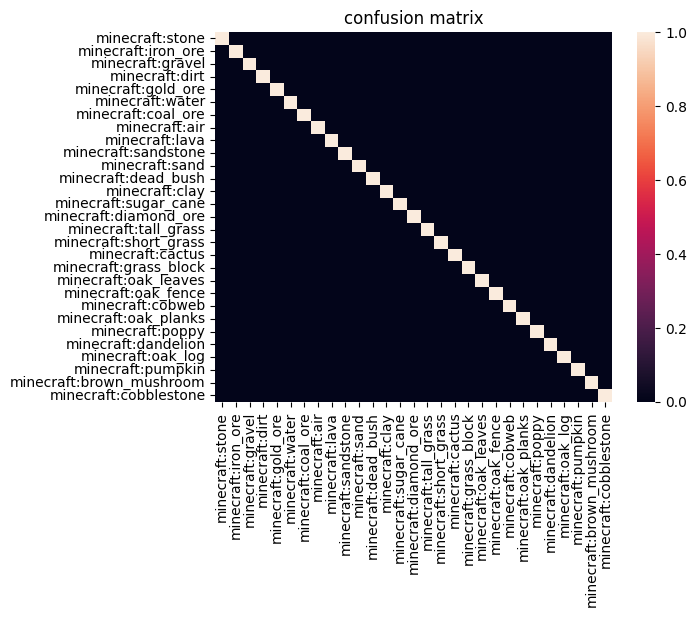

In [15]:
mean_z, _, _ = encoder.predict(vae_validation_data_x)
result = decoder.predict(mean_z)
blocks_in = vae_validation_data_x.reshape(DISTINCT_BLOCKS)
blocks_out = np.argmax(result, axis=4).reshape(DISTINCT_BLOCKS)
matrix = sklearn.metrics.confusion_matrix(blocks_in, blocks_out)
sns.heatmap(matrix, xticklabels=PALETTE['block_type'], yticklabels=PALETTE['block_type']).set_title('confusion matrix')

1/1 [==============================] - 0s 18ms/step


Text(0.5, 1.0, 'distance matrix in latent space for each class')

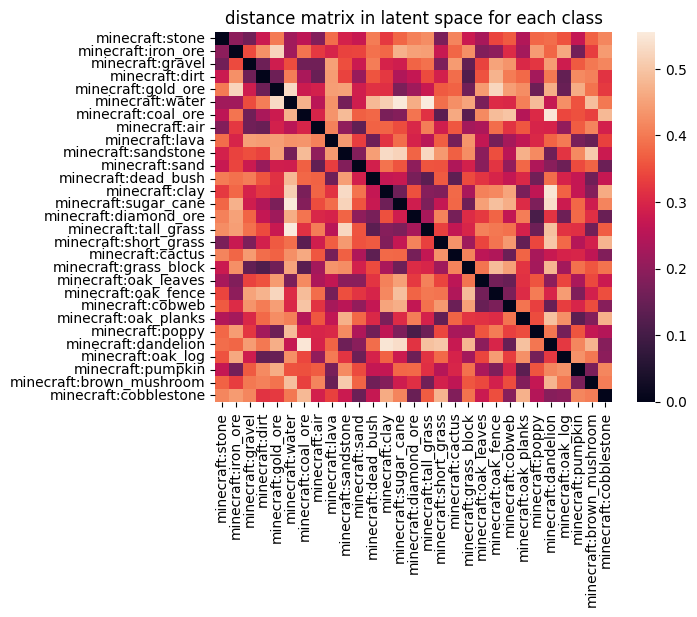

In [290]:
mean_z, _, _ = encoder.predict(vae_validation_data_x)
distances = sklearn.metrics.pairwise_distances(np.array(mean_z).reshape(DISTINCT_BLOCKS, latent_dimensions))
sns.heatmap(distances, xticklabels=PALETTE['block_type'], yticklabels=PALETTE['block_type']).set_title('distance matrix in latent space for each class')

In [291]:
things = []
for i in range(0, DISTINCT_BLOCKS):
    for j in range(0, DISTINCT_BLOCKS):
        if i <= j:
            continue
        things.append((PALETTE['block_type'][i], PALETTE['block_type'][j], distances[i,j]))

things.sort(key=lambda t: t[2])
things = pd.DataFrame(things, columns=['block1', 'block2', 'distance'])
display(things)

,block1,block2,distance
0,minecraft:poppy,minecraft:diamond_ore,0.106800
1,minecraft:grass_block,minecraft:dirt,0.116008
2,minecraft:grass_block,minecraft:coal_ore,0.128922
3,minecraft:pumpkin,minecraft:oak_planks,0.131515
4,minecraft:tall_grass,minecraft:dead_bush,0.131558
...,...,...,...
401,minecraft:dandelion,minecraft:sugar_cane,0.534551
402,minecraft:dandelion,minecraft:clay,0.546308
403,minecraft:dandelion,minecraft:coal_ore,0.547347
404,minecraft:sugar_cane,minecraft:water,0.551102


## Saving

In [306]:
are_you_sure = True #@param {type: "boolean"}

if are_you_sure:
    encoder.save(os.path.join(MODELS_PATH, encoder_file))
    decoder.save(os.path.join(MODELS_PATH, decoder_file))
    print("encoder and decoder saved!")

encoder and decoder saved!


# Diffusion

In [32]:
batch_size = 64
total_timesteps = 500
norm_groups = 8  # Number of groups used in GroupNormalization layer
learning_rate = 2e-4

img_size = 16
img_channels = 3

first_conv_channels = 32
channel_multiplier = [1, 2, 4, 8]
widths = [first_conv_channels * mult for mult in channel_multiplier]
has_attention = [False, True, True, True]
num_res_blocks = 2

## Construction

In [34]:
class GaussianDiffusion:
    """Gaussian diffusion utility.

    Args:
        beta_start: Start value of the scheduled variance
        beta_end: End value of the scheduled variance
        timesteps: Number of time steps in the forward process
    """

    def __init__(
        self,
        beta_start=1e-4,
        beta_end=0.02,
        timesteps=1000
    ):
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.timesteps = timesteps

        # Define the linear variance schedule
        self.betas = betas = np.linspace(
            beta_start,
            beta_end,
            timesteps,
            dtype=np.float64,  # Using float64 for better precision
        )
        self.num_timesteps = int(timesteps)

        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

        self.betas = tf.constant(betas, dtype=tf.float32)
        self.alphas_cumprod = tf.constant(alphas_cumprod, dtype=tf.float32)
        self.alphas_cumprod_prev = tf.constant(alphas_cumprod_prev, dtype=tf.float32)

        # Calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = tf.constant(
            np.sqrt(alphas_cumprod), dtype=tf.float32
        )

        self.sqrt_one_minus_alphas_cumprod = tf.constant(
            np.sqrt(1.0 - alphas_cumprod), dtype=tf.float32
        )

        self.log_one_minus_alphas_cumprod = tf.constant(
            np.log(1.0 - alphas_cumprod), dtype=tf.float32
        )

        self.sqrt_recip_alphas_cumprod = tf.constant(
            np.sqrt(1.0 / alphas_cumprod), dtype=tf.float32
        )
        self.sqrt_recipm1_alphas_cumprod = tf.constant(
            np.sqrt(1.0 / alphas_cumprod - 1), dtype=tf.float32
        )

        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        self.posterior_variance = tf.constant(posterior_variance, dtype=tf.float32)

        # Log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        self.posterior_log_variance_clipped = tf.constant(
            np.log(np.maximum(posterior_variance, 1e-20)), dtype=tf.float32
        )

        self.posterior_mean_coef1 = tf.constant(
            betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod),
            dtype=tf.float32,
        )

        self.posterior_mean_coef2 = tf.constant(
            (1.0 - alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - alphas_cumprod),
            dtype=tf.float32,
        )

    def _extract(self, a, t, x_shape):
        """Extract some coefficients at specified timesteps,
        then reshape to [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.

        Args:
            a: Tensor to extract from
            t: Timestep for which the coefficients are to be extracted
            x_shape: Shape of the current batched samples
        """
        batch_size = x_shape[0]
        out = tf.gather(a, t)
        return tf.reshape(out, [batch_size, 1, 1, 1, 1])

    def q_mean_variance(self, x_start, t):
        """Extracts the mean, and the variance at current timestep.

        Args:
            x_start: Initial sample (before the first diffusion step)
            t: Current timestep
        """
        x_start_shape = tf.shape(x_start)
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start_shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start_shape)
        log_variance = self._extract(
            self.log_one_minus_alphas_cumprod, t, x_start_shape
        )
        return mean, variance, log_variance

    def q_sample(self, x_start, t, noise):
        """Diffuse the data.

        Args:
            x_start: Initial sample (before the first diffusion step)
            t: Current timestep
            noise: Gaussian noise to be added at the current timestep
        Returns:
            Diffused samples at timestep `t`
        """
        x_start_shape = tf.shape(x_start)
        return (
            self._extract(self.sqrt_alphas_cumprod, t, tf.shape(x_start)) * x_start
            + self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start_shape)
            * noise
        )

    def predict_start_from_noise(self, x_t, t, noise):
        x_t_shape = tf.shape(x_t)
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t_shape) * x_t
            - self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t_shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        """Compute the mean and variance of the diffusion
        posterior q(x_{t-1} | x_t, x_0).

        Args:
            x_start: Stating point(sample) for the posterior computation
            x_t: Sample at timestep `t`
            t: Current timestep
        Returns:
            Posterior mean and variance at current timestep
        """

        x_t_shape = tf.shape(x_t)
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t_shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t_shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t_shape)
        posterior_log_variance_clipped = self._extract(
            self.posterior_log_variance_clipped, t, x_t_shape
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, pred_noise, x, t):
        x_recon = self.predict_start_from_noise(x, t=t, noise=pred_noise)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t
        )
        return model_mean, posterior_variance, posterior_log_variance

    def p_sample(self, pred_noise, x, t):
        """Sample from the diffusion model.

        Args:
            pred_noise: Noise predicted by the diffusion model
            x: Samples at a given timestep for which the noise was predicted
            t: Current timestep
        """
        model_mean, _, model_log_variance = self.p_mean_variance(
            pred_noise, x=x, t=t
        )
        noise = tf.random.normal(shape=x.shape, dtype=x.dtype)
        # No noise when t == 0
        nonzero_mask = tf.reshape(
            1 - tf.cast(tf.equal(t, 0), tf.float32), [tf.shape(x)[0], 1, 1, 1]
        )
        return model_mean + nonzero_mask * tf.exp(0.5 * model_log_variance) * noise


In [35]:
import math

# Kernel initializer to use
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return keras.initializers.VarianceScaling(
        scale, mode="fan_avg", distribution="uniform"
    )


class AttentionBlock(layers.Layer):
    """Applies self-attention.

    Args:
        units: Number of units in the dense layers
        groups: Number of groups to be used for GroupNormalization layer
    """

    def __init__(self, units, groups=8, **kwargs):
        self.units = units
        self.groups = groups
        super().__init__(**kwargs)

        self.norm = layers.GroupNormalization(groups=groups)
        self.query = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.key = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.value = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.proj = layers.Dense(units, kernel_initializer=kernel_init(0.0))

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        y = tf.shape(inputs)[1]
        xz = tf.shape(inputs)[2]
        scale = tf.cast(self.units, tf.float32) ** (-0.5)

        inputs = self.norm(inputs)
        q = self.query(inputs)
        k = self.key(inputs)
        v = self.value(inputs)

        attn_score = tf.einsum("byxzc, bYXZc->byxzYXZ", q, k) * scale
        attn_score = tf.reshape(attn_score, [batch_size, y, xz, xz, y * xz * xz])

        attn_score = tf.nn.softmax(attn_score, -1)
        attn_score = tf.reshape(attn_score, [batch_size, y, xz, xz, y, xz, xz])

        proj = tf.einsum("byxzYXZ,bYXZc->byxzc", attn_score, v)
        proj = self.proj(proj)
        return inputs + proj


class TimeEmbedding(layers.Layer):
    def __init__(self, dim, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.half_dim = dim // 2
        self.emb = math.log(10000) / (self.half_dim - 1)
        self.emb = tf.exp(tf.range(self.half_dim, dtype=tf.float32) * -self.emb)

    def call(self, inputs):
        inputs = tf.cast(inputs, dtype=tf.float32)
        emb = inputs[:, None] * self.emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb


def ResidualBlock(width, groups=8, activation_fn=keras.activations.swish):
    def apply(inputs):
        x, t = inputs
        input_width = x.shape[3]

        if input_width == width:
            residual = x
        else:
            residual = layers.Conv3D(
                width, kernel_size=1, kernel_initializer=kernel_init(1.0)
            )(x)

        temb = activation_fn(t)
        temb = layers.Dense(width, kernel_initializer=kernel_init(1.0))(temb)[
            :, None, None, None, :
        ]

        x = layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)
        x = layers.Conv3D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0)
        )(x)

        x = layers.Add()([x, temb])
        x = layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)

        x = layers.Conv3D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(0.0)
        )(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownSample(width):
    def apply(x):
        x = layers.Conv3D(
            width,
            kernel_size=3,
            strides=2,
            padding="same",
            kernel_initializer=kernel_init(1.0),
        )(x)
        return x

    return apply


def UpSample(width, interpolation="nearest"):
    def apply(x):
        x = layers.UpSampling3D(size=2)(x) # interpolation=interpolation
        x = layers.Conv3D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0)
        )(x)
        return x

    return apply


def TimeMLP(units, activation_fn=keras.activations.swish):
    def apply(inputs):
        temb = layers.Dense(
            units, activation=activation_fn, kernel_initializer=kernel_init(1.0)
        )(inputs)
        temb = layers.Dense(units, kernel_initializer=kernel_init(1.0))(temb)
        return temb

    return apply


def build_model(
    in_y,
    in_xz,
    channels,
    widths,
    has_attention,
    num_res_blocks=2,
    norm_groups=8,
    interpolation="nearest",
    activation_fn=keras.activations.swish,
):
    image_input = layers.Input(
        shape=(in_y, in_xz, in_xz, channels), name="image_input"
    )
    time_input = keras.Input(shape=(), dtype=tf.int64, name="time_input")

    x = layers.Conv3D(
        first_conv_channels,
        kernel_size=3,
        padding="same",
        kernel_initializer=kernel_init(1.0),
    )(image_input)

    temb = TimeEmbedding(dim=first_conv_channels * 4)(time_input)
    temb = TimeMLP(units=first_conv_channels * 4, activation_fn=activation_fn)(temb)

    skips = [x]

    # DownBlock
    for i in range(len(widths)):
        for _ in range(num_res_blocks):
            x = ResidualBlock(
                widths[i], groups=norm_groups, activation_fn=activation_fn
            )([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)
            skips.append(x)

        if widths[i] != widths[-1]:
            x = DownSample(widths[i])(x)
            skips.append(x)

    # MiddleBlock
    x = ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)(
        [x, temb]
    )
    x = AttentionBlock(widths[-1], groups=norm_groups)(x)
    x = ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)(
        [x, temb]
    )

    # UpBlock
    for i in reversed(range(len(widths))):
        for _ in range(num_res_blocks + 1):
            y = skips.pop()
            x = layers.Concatenate(axis=-1)([x, y])
            x = ResidualBlock(
                widths[i], groups=norm_groups, activation_fn=activation_fn
            )([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)

        if i != 0:
            x = UpSample(widths[i], interpolation=interpolation)(x)

    # End block
    x = layers.GroupNormalization(groups=norm_groups)(x)
    x = activation_fn(x)
    x = layers.Conv3D(3, kernel_size=3, padding="same", kernel_initializer=kernel_init(0.0))(x)
    return keras.Model([image_input, time_input], x, name="unet")


In [36]:
class DiffusionModel(keras.Model):
    def __init__(self, network, ema_network, timesteps, gdf_util, ema=0.999):
        super().__init__()
        self.network = network
        self.ema_network = ema_network
        self.timesteps = timesteps
        self.gdf_util = gdf_util
        self.ema = ema

    def train_step(self, images):
        # 1. Get the batch size
        batch_size = tf.shape(images)[0]

        # 2. Sample timesteps uniformly
        t = tf.random.uniform(
            minval=0, maxval=self.timesteps, shape=(batch_size,), dtype=tf.int64
        )

        with tf.GradientTape() as tape:
            # 3. Sample random noise to be added to the images in the batch
            noise = tf.random.normal(shape=tf.shape(images), dtype=images.dtype)

            # 4. Diffuse the images with noise
            images_t = self.gdf_util.q_sample(images, t, noise)
            # 5. Pass the diffused images and time steps to the network
            pred_noise = self.network([images_t, t], training=True)

            # 6. Calculate the loss
            loss = self.loss(noise, pred_noise)

        # 7. Get the gradients
        gradients = tape.gradient(loss, self.network.trainable_weights)

        # 8. Update the weights of the network
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        # 9. Updates the weight values for the network with EMA weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(self.ema * ema_weight + (1 - self.ema) * weight)

        # 10. Return loss values
        return {"loss": loss}

    def generate_images(self, num_images=16):
        # 1. Randomly sample noise (starting point for reverse process)
        samples = tf.random.normal(
            shape=(num_images, img_size, img_size, img_size, img_channels), dtype=tf.float32
        )
        # 2. Sample from the model iteratively
        for t in reversed(range(0, self.timesteps)):
            tt = tf.cast(tf.fill(num_images, t), dtype=tf.int64)
            pred_noise = self.ema_network.predict(
                [samples, tt], verbose=0, batch_size=num_images
            )
            samples = self.gdf_util.p_sample(
                pred_noise, samples, tt
            )
        # 3. Return generated samples
        return samples

# Build the unet model
network = build_model(
    in_y = 16,
    in_xz = 16,
    channels=latent_dimensions,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    activation_fn=keras.activations.swish,
)
ema_network = build_model(
    in_y = 16,
    in_xz = 16,
    channels=latent_dimensions,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    activation_fn=keras.activations.swish,
)
ema_network.set_weights(network.get_weights())  # Initially the weights are the same

# Get an instance of the Gaussian Diffusion utilities
gdf_util = GaussianDiffusion(timesteps=total_timesteps)

# Get the model
model = DiffusionModel(
    network=network,
    ema_network=ema_network,
    gdf_util=gdf_util,
    timesteps=total_timesteps,
)

# Compile the model
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
)

## Saving, loading

In [ ]:
# TODO

## Training

### Dataset preparation

In [27]:
#@title Data pipeline

def random_top_dataset_generator(y_size, xz_size):
    while True:
        biome = np.random.randint(0, BIOME_COUNT)
        chunk_id = np.random.randint(0, TOPS_DATASET[biome].shape[0])
        yield (biome, chunk_id, 0, 0, 0, y_size, xz_size)

def fetch_top_array(biome_id, chunk_id, pos_y, pos_x, pos_z, y_size, xz_size):
    arr = np.zeros((y_size, xz_size, xz_size)).astype(np.uint8)
    pos_ym = pos_y+y_size
    pos_xm = pos_x+xz_size
    pos_zm = pos_z+xz_size
    arr[:,:,:] = TOPS_DATASET[biome_id][chunk_id, pos_y:pos_ym, pos_x:pos_xm, pos_z:pos_zm]
    return arr

def wrapped_fetch_top_array(biome_id, chunk_id, pos_y, pos_x, pos_z, y_size, xz_size):
    return tf.numpy_function(func = fetch_top_array,
                      inp = (biome_id, chunk_id, pos_y, pos_x, pos_z, y_size, xz_size),
                      Tout = (tf.uint8))

def create_tops_dataset_from_generator(y, xz):
    return tf.data.Dataset.from_generator(
        random_top_dataset_generator,
        output_types=(tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32),
        output_shapes=([], [], [], [], [], [], []),
        args=(y, xz)
    ).map( # Parallelize map transformation
        wrapped_fetch_top_array,
        num_parallel_calls=tf.data.AUTOTUNE
    )

tops_training_dataset = create_tops_dataset_from_generator(16, 16) \
    .batch(256) \
    .prefetch(tf.data.AUTOTUNE)

# testing:
print(next(iter(create_tops_dataset_from_generator(16, 16))).shape)

(16, 16, 16)


In [57]:
diffusion_feed = create_tops_dataset_from_generator(16, 16) \
    .batch(256) \
    .prefetch(tf.data.AUTOTUNE)


z_mean, _, _ = encoder.predict(diffusion_feed, steps=1)
diffusion_training_data = z_mean
print(diffusion_training_data.shape)

1/1 [==============================] - 0s 423ms/step
(256, 16, 16, 16, 3)


### actual training

In [58]:
model.fit(
    diffusion_training_data,
    epochs=50,
    batch_size=batch_size,
)

Epoch 1/50
4/4 [==============================] - 4s 875ms/step - loss: 0.0210
Epoch 2/50
4/4 [==============================] - 4s 881ms/step - loss: 0.0246
Epoch 3/50
4/4 [==============================] - 4s 887ms/step - loss: 0.0230
Epoch 4/50
4/4 [==============================] - 4s 891ms/step - loss: 0.0339
Epoch 5/50
4/4 [==============================] - 4s 899ms/step - loss: 0.0191
Epoch 6/50
4/4 [==============================] - 4s 899ms/step - loss: 0.0282
Epoch 7/50
4/4 [==============================] - 4s 933ms/step - loss: 0.0241
Epoch 8/50
4/4 [==============================] - 4s 879ms/step - loss: 0.0202
Epoch 9/50
4/4 [==============================] - 3s 873ms/step - loss: 0.0164
Epoch 10/50
4/4 [==============================] - 3s 876ms/step - loss: 0.0268
Epoch 11/50
4/4 [==============================] - 3s 865ms/step - loss: 0.0247
Epoch 12/50
4/4 [==============================] - 3s 866ms/step - loss: 0.0237
Epoch 13/50
4/4 [==============================] 

In [38]:
input = np.random.normal(0, 1, (1, 16, 16, 16, 3))
decoded = decoder.predict(input)

1/1 [==============================] - 0s 143ms/step


In [ ]:
samples = tf.random.normal(
    shape=(1, 16, 16, 16, img_channels), dtype=tf.float32
)

for t in reversed(range(0, model.timesteps)):
    print(f'{t}/{model.timesteps}')
    tt = tf.cast(tf.fill(1, t), dtype=tf.int64)
    pred_noise = model.ema_network.predict(
        [samples, tt], verbose=0, batch_size=1
    )
    samples = model.gdf_util.p_sample(
        pred_noise, samples, tt
    )

In [64]:
samples = diffusion_training_data[0].reshape((1,16,16,16,3))
decoded = decoder.predict(samples)
send_to_mc(np.argmax(decoded,axis=-1)[0])

for t in reversed(range(0, model.timesteps)):
    print(f'{t}/{model.timesteps}')
    tt = tf.cast(tf.fill(1, t), dtype=tf.int64)
    pred_noise = model.ema_network.predict(
        [samples, tt], verbose=0, batch_size=1
    )
    samples = model.gdf_util.p_sample(
        pred_noise, samples, tt
    )
    decoded = decoder.predict(samples)
    send_to_mc(np.argmax(decoded,axis=-1)[0])

1/1 [==============================] - 0s 26ms/step
(16, 16, 16)
<Response [200]>
499/500
1/1 [==============================] - 0s 82ms/step
(16, 16, 16)
<Response [200]>
498/500
1/1 [==============================] - 0s 40ms/step
(16, 16, 16)
<Response [200]>
497/500
1/1 [==============================] - 0s 17ms/step
(16, 16, 16)
<Response [200]>
496/500
1/1 [==============================] - 0s 16ms/step
(16, 16, 16)
<Response [200]>
495/500
1/1 [==============================] - 0s 17ms/step
(16, 16, 16)
<Response [200]>
494/500
1/1 [==============================] - 0s 29ms/step
(16, 16, 16)
<Response [200]>
493/500
1/1 [==============================] - 0s 27ms/step
(16, 16, 16)
<Response [200]>
492/500
1/1 [==============================] - 0s 28ms/step
(16, 16, 16)
<Response [200]>
491/500
1/1 [==============================] - 0s 26ms/step
(16, 16, 16)
<Response [200]>
490/500
1/1 [==============================] - 0s 16ms/step
(16, 16, 16)
<Response [200]>
489/500
1/1 [=====

KeyboardInterrupt: 

In [54]:
print(samples.shape)
decoded_diffused = decoder.predict(samples)

(1, 16, 16, 16, 3)
1/1 [==============================] - 0s 29ms/step


In [233]:
random = tf.random.normal(
    mean=5.0,
    stddev=10.0,
    shape=(1, 16, 16, 16, img_channels), dtype=tf.float32
)
random_decoded = decoder.predict(samples)

1/1 [==============================] - 0s 18ms/step
[[[[28 21  2 ...  4 22  2]
   [ 4 22 21 ...  0  5  5]
   [16  5  1 ...  3  3  9]
   ...
   [28 15 28 ... 19  7 26]
   [ 0 19 18 ... 27  8  4]
   [ 0 25  8 ... 13 28  1]]

  [[ 6  7  0 ... 10  6  0]
   [ 0  9 26 ...  5  7  9]
   [20  6  4 ... 13 16  7]
   ...
   [ 2  1 19 ... 15 26 16]
   [ 4  8  6 ... 28 13 20]
   [25  9  6 ...  0 12  3]]

  [[ 2  5  5 ...  1  3 25]
   [25  7 20 ... 17  7 16]
   [ 3 13  7 ... 11 13  6]
   ...
   [16  1 22 ...  0 17 22]
   [ 6 20  4 ... 14 24 24]
   [10 15  7 ... 23 19  7]]

  ...

  [[ 7 23 13 ...  3 14  9]
   [11 28 26 ... 25  6  3]
   [ 3 23  0 ... 25  0  8]
   ...
   [11 20  9 ...  4  2  0]
   [ 5 26 16 ... 23 13  4]
   [ 2  6 19 ... 17  2 23]]

  [[25 17  9 ...  5  7 22]
   [10 25 19 ... 22 20  4]
   [24 15 27 ... 24 23  0]
   ...
   [11  7 20 ...  5  9  1]
   [ 0 23  1 ...  7  0  0]
   [24  8 20 ...  6 27 17]]

  [[ 3  2 25 ... 20 17 23]
   [17 24 14 ... 13  4  7]
   [ 2 23  9 ... 25  5 25]
   ..

In [42]:
import requests
import numpy as np
from tempfile import TemporaryFile

def send_to_mc(data):
    out = TemporaryFile()
    np.savez(out, data)
    out.seek(0, 0)
    out.flush()
    req = requests.post("https://oriented-goshawk-model.ngrok-free.app/upload",
                  files={"file": ('data.npz', out.read())})
    print(data.shape)
    print(req)

In [56]:
send_to_mc(np.argmax(decoded_diffused,axis=-1)[0])

(16, 16, 16)
<Response [200]>


In [53]:
decoded_training_data = decoder.predict(diffusion_training_data)
send_to_mc(np.argmax(decoded_training_data[0], axis=-1))

8/8 [==============================] - 0s 10ms/step
(16, 16, 16)
<Response [200]>
